# Package

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Set up environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_sup_dataset import load_train_test

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = load_train_test()



>> Loading the trainset
Total images are 93408




>> Loading the testset
Total images are 98904




In [6]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, shuffle = False, num_workers = 4)
len(trainloader), len(valloader)

(365, 387)

torch.Size([256, 3, 224, 224]) torch.Size([256])


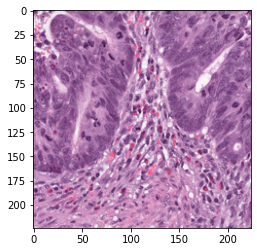

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# Baseline Model

In [8]:
from trainer.supervised.baseline_trainer import BaseLineTrainer

run_on = "CRC_DX"

In [9]:
baseline_trainer = BaseLineTrainer(trainloader, valloader, num_cycle = 5, valset = valset, netname = "ResNet18")
max_epochs = baseline_trainer.get_max_epochs()

In [10]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", run_on, "baseline")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline'

In [11]:
tb_logger = loggers.TensorBoardLogger('logs/' + run_on, name = "baseline")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


## Learning finder

In [12]:
lr_finder = trainer.lr_find(baseline_trainer)

INFO:lightning:
   | Name                               | Type              | Params
---------------------------------------------------------------------
0  | criterion                          | BCEWithLogitsLoss | 0     
1  | model                              | BaseLineModel     | 11 M  
2  | model.resnet                       | ResNet            | 11 M  
3  | model.resnet.conv1                 | Conv2d            | 9 K   
4  | model.resnet.bn1                   | BatchNorm2d       | 128   
5  | model.resnet.relu                  | ReLU              | 0     
6  | model.resnet.maxpool               | MaxPool2d         | 0     
7  | model.resnet.layer1                | Sequential        | 147 K 
8  | model.resnet.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet.layer1.0.relu         | ReLU              | 0     
12 | model.resnet

INFO:lightning:LR finder stopped early due to diverging loss.


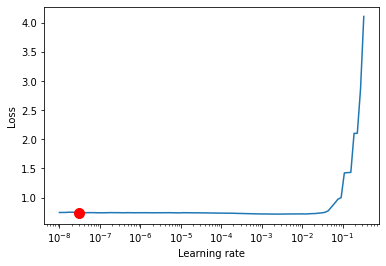

In [13]:
fig = lr_finder.plot(suggest=True)

In [12]:
baseline_trainer.base_lr = 1e-4
baseline_trainer.max_lr = 1e-2
baseline_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.002
    lr: 0.002
    max_lr: 0.01
    max_momentum: 0.95
    min_lr: 2e-07
    momentum: 0.95
    nesterov: False
    weight_decay: 1e-05
)

## Train model

In [13]:
trainer.fit(baseline_trainer)

INFO:lightning:
   | Name                               | Type              | Params
---------------------------------------------------------------------
0  | criterion                          | BCEWithLogitsLoss | 0     
1  | model                              | BaseLineModel     | 11 M  
2  | model.resnet                       | ResNet            | 11 M  
3  | model.resnet.conv1                 | Conv2d            | 9 K   
4  | model.resnet.bn1                   | BatchNorm2d       | 128   
5  | model.resnet.relu                  | ReLU              | 0     
6  | model.resnet.maxpool               | MaxPool2d         | 0     
7  | model.resnet.layer1                | Sequential        | 147 K 
8  | model.resnet.layer1.0              | BasicBlock        | 73 K  
9  | model.resnet.layer1.0.conv1        | Conv2d            | 36 K  
10 | model.resnet.layer1.0.bn1          | BatchNorm2d       | 128   
11 | model.resnet.layer1.0.relu         | ReLU              | 0     
12 | model.resnet

INFO:lightning:
Epoch 00000: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=0_v1.ckpt


INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=1_v3.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=2_v3.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=3_v3.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=4_v3.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=5_v3.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=6_v3.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=7_v3.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=8_v3.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=9_v3.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=10_v3.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=11_v3.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=12_v3.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=13_v3.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=14_v3.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=15_v3.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=16_v3.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=17_v3.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=18_v3.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=19_v3.ckpt


INFO:lightning:
Epoch 00020: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=20_v3.ckpt


INFO:lightning:
Epoch 00021: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=21_v3.ckpt


INFO:lightning:
Epoch 00022: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=22_v2.ckpt


INFO:lightning:
Epoch 00023: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=23_v2.ckpt


INFO:lightning:
Epoch 00024: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/CRC_DX/baseline/epoch=24_v1.ckpt


1